# Project 2 – Bag-of-Words Image Classifier 

Francesca Bazzo IN2000240

## Introduction

This project implements an image classifier based on the bag-of-words approach.

The dataset contains 15 categories (office, kitchen, living room, bedroom, store, industrial, tall building, inside city, street, highway, coast, open country, mountain, forest, suburb) and is divided into train and test. 

## Environment Setup


In [1]:
# Import required libraries
import numpy as np
import pandas as pd 
import cv2 as cv
import os
import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle 
from scipy.spatial.distance import cdist  
from kneed import KneeLocator 
from tqdm import tqdm

## Dataset Loading and Exploration

The training and test sets are loaded, the images are converted to gray and then a sample image is visualized. 

In [2]:
#   Load dataset 

dataset = []

for split in ["train", "test"]:
    for class_name in os.listdir(f"./data/{split}"):
        class_dir = os.path.join(f"./data/{split}", class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_path in glob.glob(os.path.join(class_dir, "*.jpg")):
            img = cv.imread(img_path)
            if img is None:
                continue  
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # convert for SIFT
            dataset.append((img, class_name, split))



Shape: (200, 267)
Label: Bedroom
Split: train


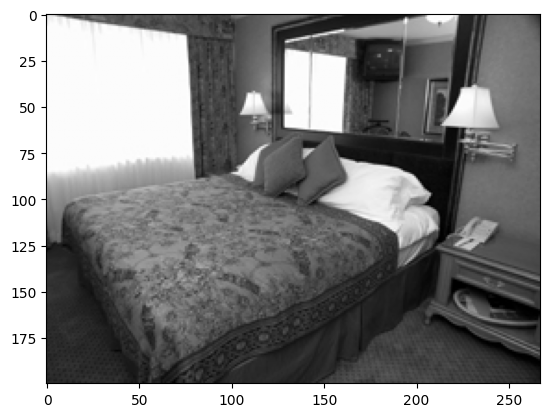

In [4]:
img0, label0, split0 = dataset[0]
print("Shape:", img0.shape)
print("Label:", label0)
print("Split:", split0)

plt.imshow(img0, cmap="gray")

## 1. Build a visual vocabulary 

- Sample many (10K to 100K) SIFT descriptors from the images of the training set (you either use a detector or sample on a grid in the scale-space);
- cluster them using k-means (the choice of the number of clusters is up to you, and you should experiment with different values, but you could start with a few dozens);
- collect (and save for future use) the clusters’ centroids which represent the k 128-dimensional visual words.

**SIFT Feature Extraction**

Many SIFT descriptors are sampled from the images of the training set. 
Since I want to have at most 100K, many are not take into consideration. 

In [3]:
sift = cv.SIFT_create() 

all_descriptors = []

for img, class_name, split in dataset:
    
    if split != "train":
        continue

    keypoints, descriptors = sift.detectAndCompute(img, None)

    if descriptors is not None:
        all_descriptors.append(descriptors)

if all_descriptors: 
    all_descriptors = np.vstack(all_descriptors)
    print(f"Descriptors extracted: {all_descriptors.shape[0]}")

    #   I want to have at most 100k descriptors 

    max_descr = 100000

    if all_descriptors.shape[0] > max_descr:
        idx = np.random.choice(all_descriptors.shape[0], max_descr, replace=False)
        sampled_descriptors = all_descriptors[idx]
    else:
        sampled_descriptors = all_descriptors

    print(f"Descriptors that will be used: {sampled_descriptors.shape[0]}")

np.save("sampled_descriptors", sampled_descriptors)


Descriptors extracted: 762342
Descriptors that will be used: 100000


**Visual Vocabulary Construction** 

K-means needs to be applied and the centroids saved as visual words. 

In [4]:
sampled_descriptors = np.load("sampled_descriptors.npy")

To find the optimal value of k, two metrics are used: 

- inertia: Measures the internal cohesion of the clusters. Lower inertia indicates better cohesion, because the points are closer to the centroids. 
- silhouette score: Measures the separation between clusters. It evaluates how well each point fits within its assigned cluster compared to others.

To find an optimal value of k, it is necessary to look for **low inertia** and **high silhouette score**. 

I tried the following values of k: To find the optimal value of k, two metrics are used: 

- inertia: Measures the internal cohesion of the clusters. Lower inertia indicates better cohesion, because the points are closer to the centroids. 
- silhouette score: Measures the separation between clusters. It evaluates how well each point fits within its assigned cluster compared to others.

To find an optimal value of k, it is necessary to look for **low inertia** and **high silhouette score**. 

I tried the following values of k: To find the optimal value of k, two metrics are used: 

- inertia: Measures the internal cohesion of the clusters. Lower inertia indicates better cohesion, because the points are closer to the centroids. 
- silhouette score: Measures the separation between clusters. It evaluates how well each point fits within its assigned cluster compared to others.

To find an optimal value of k, it is necessary to look for **low inertia** and **high silhouette score**. 

I tried the following values of k : [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]

In [7]:
k_values = np.linspace(10, 200, num=10, dtype=int).tolist()  
print(k_values)

inertia_values = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(sampled_descriptors)
    labels = kmeans.labels_

    #   inertia: cohesion 
    inertia = kmeans.inertia_
    inertia_values.append(inertia)
    
    #   silhouette score: separation
    silhouette = silhouette_score(sampled_descriptors, kmeans.labels_)
    silhouette_scores.append(silhouette)

    print(f"For k={k}: inertia={inertia} and silhouette={silhouette}")

[10, 31, 52, 73, 94, 115, 136, 157, 178, 200]
For k=10: inertia=10773354496.0 and silhouette=0.04988345876336098
For k=31: inertia=9412805632.0 and silhouette=0.043537456542253494
For k=52: inertia=8887947264.0 and silhouette=0.04015275835990906
For k=73: inertia=8562505216.0 and silhouette=0.04003911465406418
For k=94: inertia=8334812160.0 and silhouette=0.03590075299143791
For k=115: inertia=8164434944.0 and silhouette=0.03419969603419304
For k=136: inertia=8022348288.0 and silhouette=0.03224143385887146
For k=157: inertia=7891526656.0 and silhouette=0.03223755955696106
For k=178: inertia=7792315904.0 and silhouette=0.03100714273750782
For k=200: inertia=7692844032.0 and silhouette=0.02997354418039322


To find the best k:
1. I use the **elbow method** on the graph of the inertia values, which allows me to find the number of clusters k that is high enough to represent the data without creating unnecessary, overly specific clusters.
2. I find the k with the best silhouette score.
3. If the two coincide, that is the k I will use; otherwise, I will select a k for which the silhouette score is very good without worsening too much the inertia. 


Best k according to Elbow (Inertia): 52

Best k according to Silhouette score: 10
Chosen k: 52 (Fallback to elbow or silhouette)


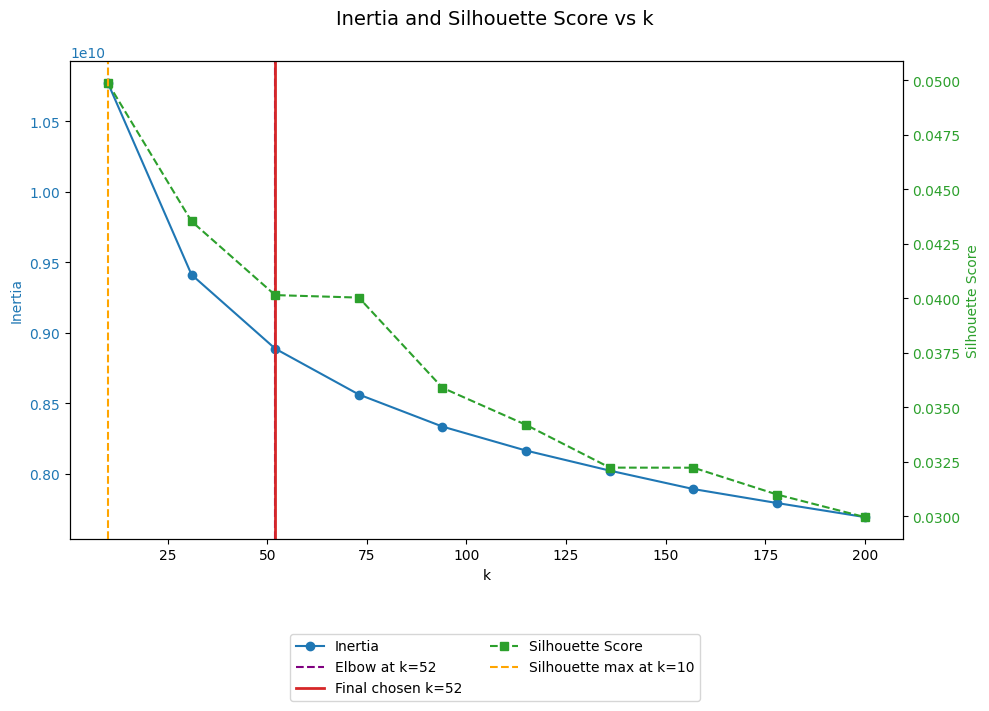

In [8]:
# 1. best k with elbow method (inertia)
kneedle = KneeLocator(k_values, inertia_values, curve="convex", direction="decreasing")
best_k_elbow = kneedle.knee

# 2. best k for silhouette score 
best_k_silhouette = k_values[np.argmax(silhouette_scores)]

print(f"\nBest k according to Elbow (Inertia): {best_k_elbow}")
print(f"\nBest k according to Silhouette score: {best_k_silhouette}")

# 3. check which one to choose 
inertia_at_elbow = inertia_values[k_values.index(best_k_elbow)] if best_k_elbow else None
inertia_at_silhouette = inertia_values[k_values.index(best_k_silhouette)]

if best_k_elbow and (inertia_at_silhouette <= 1.1 * inertia_at_elbow):
    final_best_k = best_k_silhouette
    print(f"Chosen k: {final_best_k} (Silhouette wins, inertia acceptable)")
else:
    final_best_k = best_k_elbow or best_k_silhouette
    print(f"Chosen k: {final_best_k} (Fallback to elbow or silhouette)")


# I visualize the values 

fig, ax1 = plt.subplots(figsize=(10, 6))

color_inertia = 'tab:blue'
color_silhouette = 'tab:green'
color_final_k = 'tab:red'

# left axis: silhouette score: 
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia', color=color_inertia)
ax1.plot(k_values, inertia_values, 'o-', color=color_inertia, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color_inertia)

# right axis: silhouette score 
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color=color_silhouette)
ax2.plot(k_values, silhouette_scores, 's--', color=color_silhouette, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color_silhouette)

# key points highlighted 
if best_k_elbow:
    ax1.axvline(best_k_elbow, color='purple', linestyle='--', label=f'Elbow at k={best_k_elbow}')

if best_k_silhouette:
    ax2.axvline(best_k_silhouette, color='orange', linestyle='--', label=f'Silhouette max at k={best_k_silhouette}')

if final_best_k:
    ax1.axvline(final_best_k, color=color_final_k, linestyle='-', linewidth=2, label=f'Final chosen k={final_best_k}')

fig.suptitle('Inertia and Silhouette Score vs k', fontsize=14)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout()
plt.show()

I decided to use k=52. 

Now I apply K-means and save the centroids as visual words. 


In [5]:
kmeans = KMeans(n_clusters=52, random_state=0, n_init="auto").fit(sampled_descriptors)
visual_words = kmeans.cluster_centers_ 

np.save("visual_words", visual_words )

## 2. BoW Histogram Representation

Represent each image of the training set as a normalized histogram having k bins, each corresponding to a visual word; a possibility is to perform a rather dense sampling in space and scale; another possibility is to use the SIFT detector to find the points in scale-space where the descriptor is computed. In any case, each computed descriptor will increase the value of the bin corresponding to the closest visual word.

In [6]:
# Lists initialized 
histograms = []
labels = []

k=52

# The histogram is extracted for each image in the training set 
for img, label, split in dataset: 
    if split != "train":
        continue
    keypoints, descriptors = sift.detectAndCompute(img, None)

    if descriptors is None or len(descriptors) == 0:
        hist = np.zeros(k)
    else:
        distances = cdist(descriptors, visual_words)
        closest = np.argmin(distances, axis=1)
        hist, _ = np.histogram(closest, bins=np.arange(k + 1))
        hist = hist / hist.sum()  # L1 normalization

    histograms.append(hist)
    labels.append(label)

# I save the results for that specific value of k 
np.save(f"train_histograms.npy", np.array(histograms))
np.save(f"train_labels.npy", np.array(labels))

I visualize the histogram of an image with idx=200. 

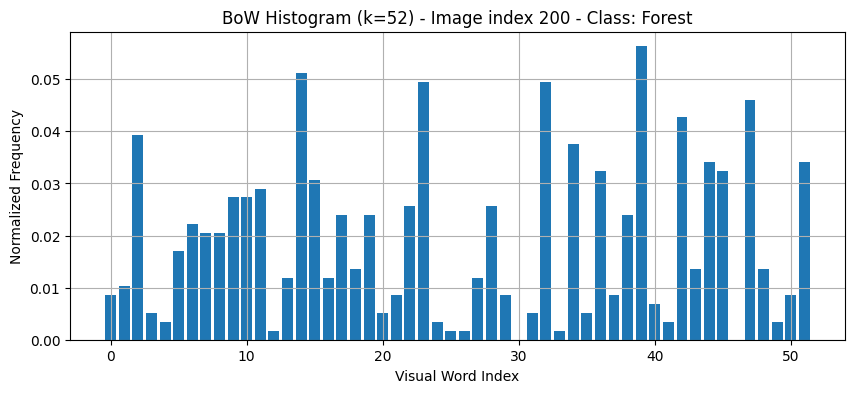

In [7]:
idx = 200

train_histograms = np.load(f"train_histograms.npy")
train_labels = np.load(f"train_labels.npy")

hist = histograms[idx]
label = labels[idx]

plt.figure(figsize=(10, 4))
plt.bar(np.arange(k), hist)
plt.xlabel("Visual Word Index")
plt.ylabel("Normalized Frequency")
plt.title(f"BoW Histogram (k={k}) - Image index {idx} - Class: {label}")
plt.grid(True)
plt.show()

## 3. Nearest Neighbor Classification

Employ a nearest neighbor classifier and evaluate its performance:
- compute the normalized histogram for the test image to be classified;
- assign to the image the class corresponding to the training image having the closest histogram.
- repeat for all the test images and build a confusion matrix.

I compute the histograms of the test images. 

In [8]:
visual_words = np.load(f"visual_words.npy")

histograms = []
labels = []

# I exctract the histogram for each image of the test set 
for img, label, split in dataset:
    if split != "test":
        continue

    keypoints, descriptors = sift.detectAndCompute(img, None)

    if descriptors is None or len(descriptors) == 0:
        hist = np.zeros(k)
    else:
        distances = cdist(descriptors, visual_words)
        closest = np.argmin(distances, axis=1)
        hist, _ = np.histogram(closest, bins=np.arange(k + 1))
        hist = hist / hist.sum()  # L1 normalization

    histograms.append(hist)
    labels.append(label)

# I save the results
np.save(f"test_histograms.npy", np.array(histograms))
np.save(f"test_labels.npy", np.array(labels))


Now I classify the test histograms.

In [9]:
test_histograms = np.load(f"test_histograms.npy")
test_labels = np.load(f"test_labels.npy")

KNN applied on k=3
Accuracy for k=3: 0.35577889447236183


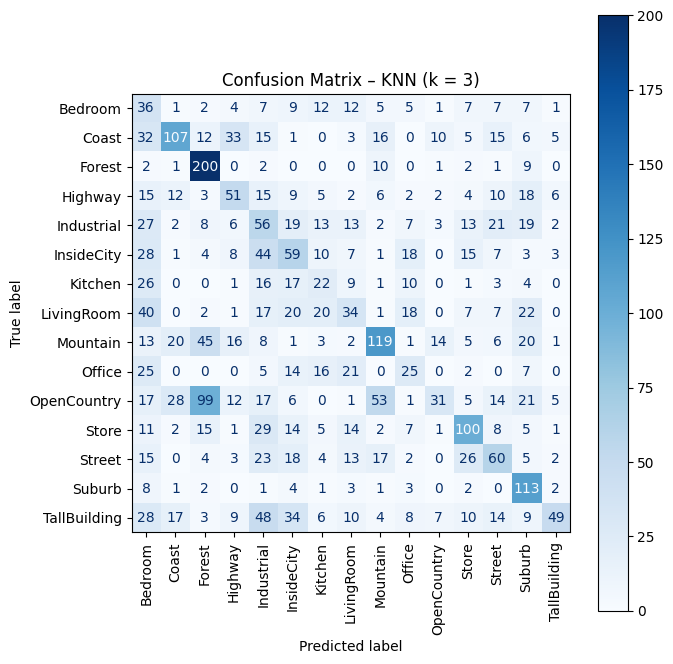

KNN applied on k=6
Accuracy for k=6: 0.3772194304857621


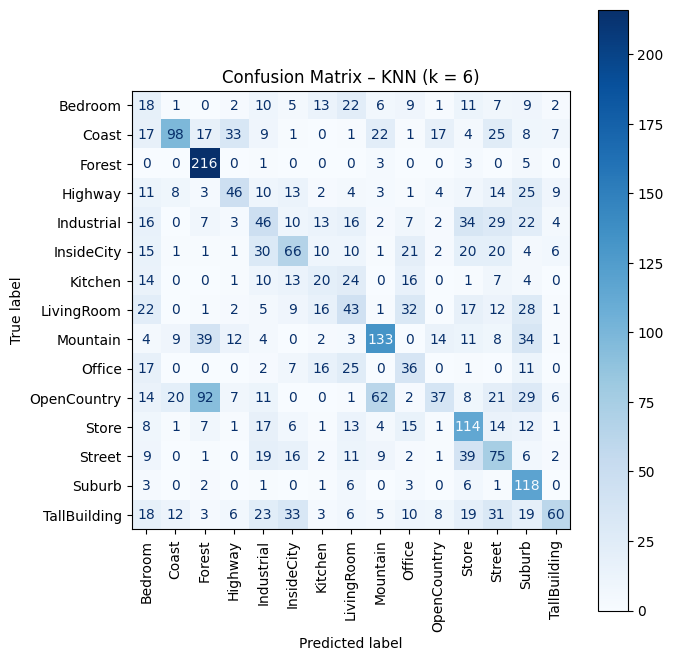

KNN applied on k=9
Accuracy for k=9: 0.3882747068676717


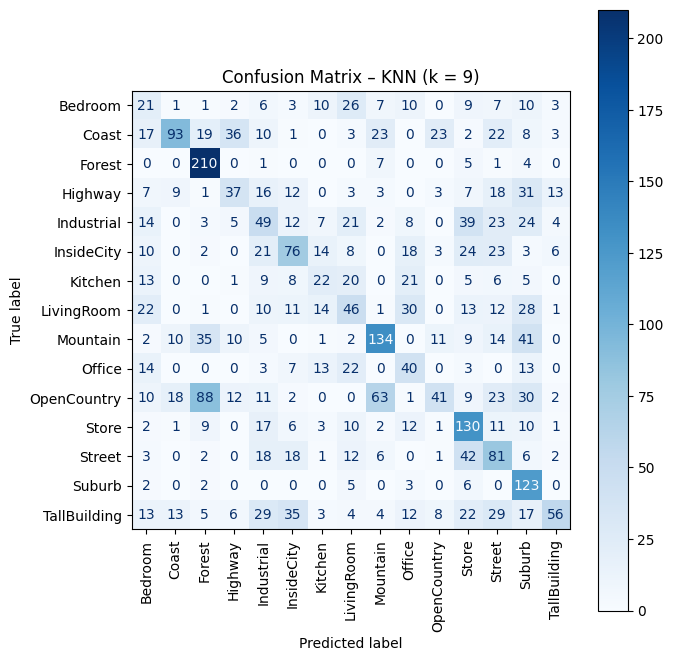

KNN applied on k=12
Accuracy for k=12: 0.3963149078726968


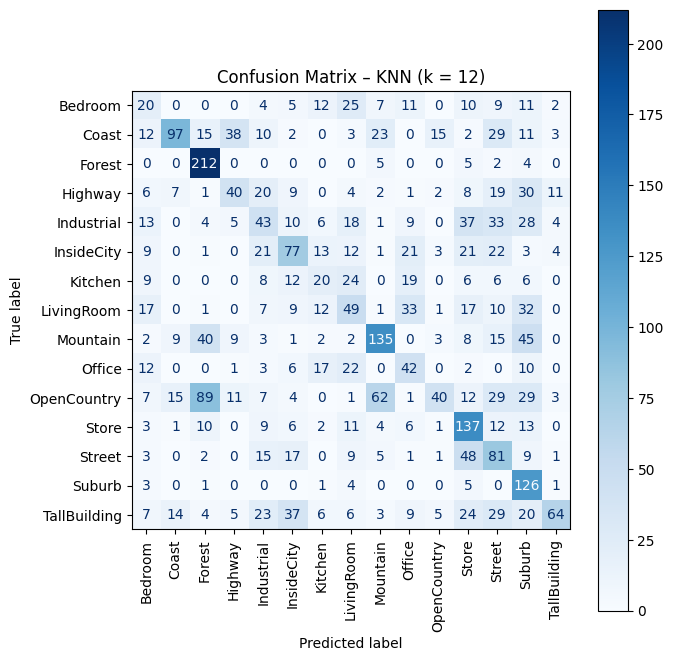

KNN applied on k=15
Accuracy for k=15: 0.39028475711892796


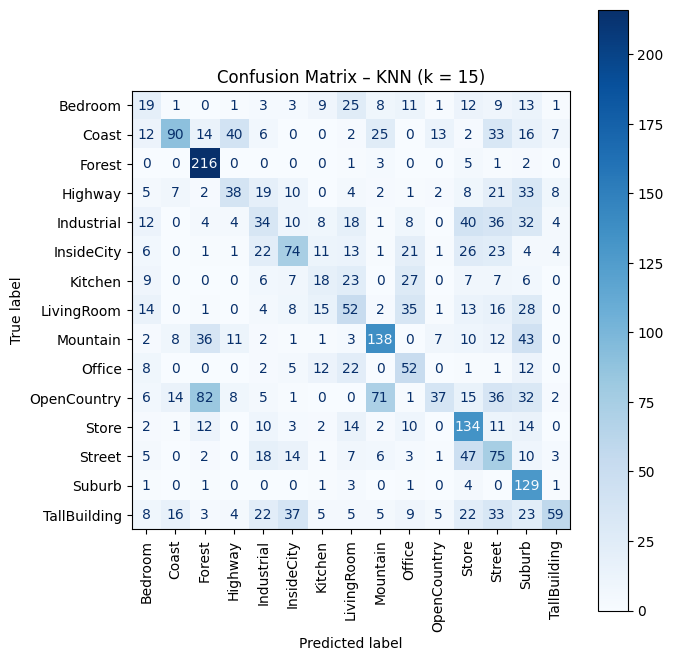

KNN applied on k=18
Accuracy for k=18: 0.38894472361809046


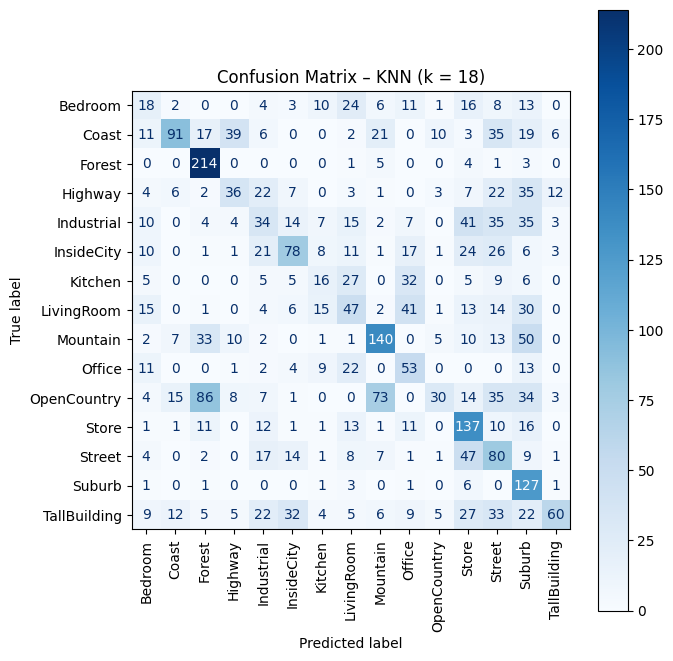

KNN applied on k=21
Accuracy for k=21: 0.3869346733668342


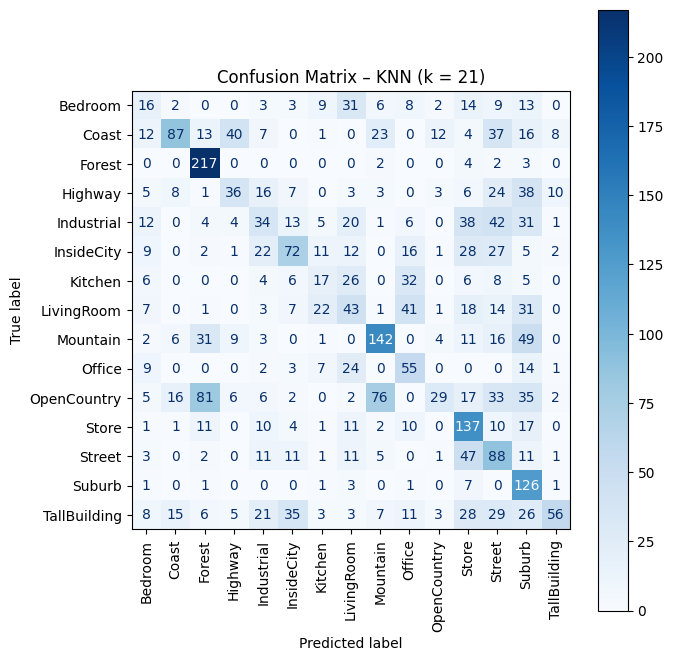

In [14]:
# knn classification for several values of k

k_neighbors = [3, 6, 9, 12, 15, 18, 21]
accuracies = {}
confusion_matrices = {}
classes = sorted(set(test_labels))  # to have consistent ordering 

for k in k_neighbors:
    print(f"KNN applied on k={k}")
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_histograms, train_labels)
    predicted_labels = knn.predict(test_histograms)

    # compute the accuracy 
    accuracy = accuracy_score(test_labels, predicted_labels)

    # compute the confusion matrix 
    cm = confusion_matrix(test_labels,predicted_labels,labels=classes)

    # store results 
    accuracies[k]=accuracy
    confusion_matrices[k]=cm 

    # print accuracies values 
    print(f"Accuracy for k={k}: {accuracy}")

    # display the confusion matrix
    fig, ax = plt.subplots(figsize=(7, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
    plt.title(f"Confusion Matrix – KNN (k = {k})")
    plt.tight_layout()
    plt.show()

The accuracies were very similar for the different values of k. 

However, the highest accuracy was for k=12, and it was equal to 0.3963; for this reason, I analyze the results of that specific case.  

The classification was very accurate for some categories:
- **Forest**: 212 out of 228 (0.92)
- **Suburb**: 126 out of 141 (0.89)

It was good for some categories such as **Store**, where 137 out of 215 (0.63) predictions were correct. 

There were, however, some categories for which the predictions not were good at all. An example of this is **OpenCountry**: only 40 correct predictions out of 310 images, it was labelled as Forest 89 times and 62 as Mountain. 


## 4. SVM Classification (One-vs-Rest)

Train a multiclass linear Support Vector Machine, using the one-vs-rest approach (you will need to train 15 binary classifiers having the normalized histograms as the input vectors and positive labels for the “one” class and negative for the “rest.”)

In [10]:
# to be sure, I do this again 
X_train = train_histograms
y_train = train_labels

X_train, y_train = shuffle(X_train, y_train, random_state=0)

class_names = np.unique(y_train)

classifiers = [] # array with all the classifiers 

for class_name in class_names: 
    y_binary = (y_train == class_name).astype(int)
    svm = SVC(kernel="linear", probability=False)
    svm.fit(X_train, y_binary)
    classifiers.append(svm)

## 5. Evaluation of the multiclass SVM

Evaluate the multiclass SVM:
- compute the normalized histogram for the test image to be classified;
- compute the real-valued output of each of the SVMs, using that histogram as input;
- assign to the image the class corresponding to the SVM having the greatest real-valued output.
- repeat for all the test images and build a confusion matrix.

The histograms of visual words for each test image were already computed in one of the previous steps.


The accuracy of the multiclass SVM is: 0.3966499162479062


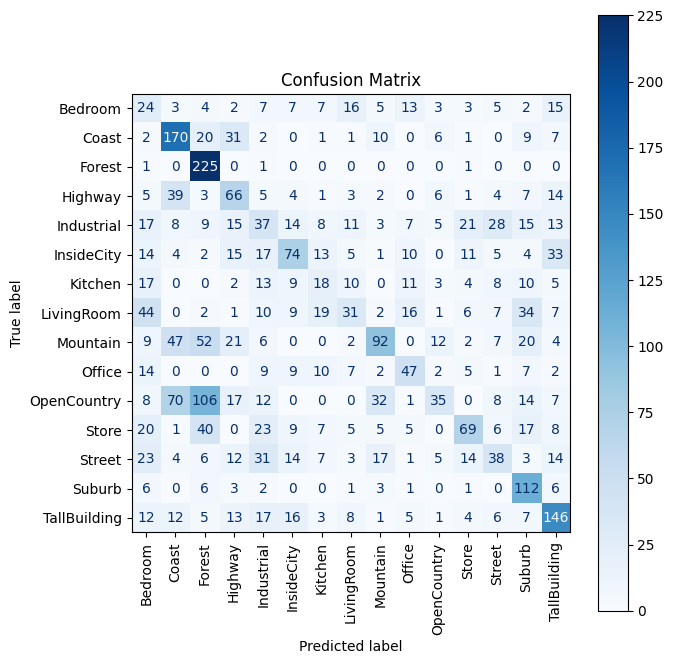

In [11]:
X_test = test_histograms
y_test_true = test_labels
y_pred = []

for hist in X_test:  
    scores = np.array([svm.decision_function([hist])[0] for svm in classifiers])
    pred_index = np.argmax(scores)
    pred_class = class_names[pred_index]
    y_pred.append(pred_class)

accuracy_svm = accuracy_score(y_test_true, y_pred)
print(f"The accuracy of the multiclass SVM is: {accuracy_svm}")

cm_predictions = confusion_matrix(y_test_true, y_pred, labels=class_names)

fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_predictions, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title(f"Confusion Matrix")
plt.tight_layout()
plt.show()
 

The accuracy was very close to the accuracy of the classification using K-means. 

The classification was very accurate for the following categories: 
- **Forest**: almost perfect classification, since 225 out of 228 images were correctly classified; 
- **Coast**: 165 out of 260 images were correctly classified (0.63);
- **Suburb**: 104 out of 135 images were correctly classified (0.77)

In this case, the classification for the **OpenCountry** images was even worse, since 107 images were classified as Forest and 53 as Coast.  

## 6. Optional: SVM with χ² Kernel

Train the SVM using a generalized Gaussian kernel (Lecture 7) based on the χ2 distance.

In this case, I use the following kernel: $k(x, x')=\text{exp}(-\frac{\chi^2(x,x')}{A})=\text{exp}(-\frac{\sum_i \frac{(t_i-t'_i)^2}{t_i+t'_i+\epsilon}}{A}) $

In order to do this, I define a function that precomputes the kernel on the specified matrices.     

In [12]:
def chi2_kernel(X, Y, A=1.0, epsilon=1e10):
    """
    Computes the generalized kernel matrix χ².

    """ 
    n_X = X.shape[0]
    n_Y = Y.shape[0]
    K = np.zeros((n_X, n_Y))

    for i in range(n_X):
        xi=X[i]
        for j in range(n_Y):
            yj=Y[j]
            chi2=np.sum(((xi-yj)**2) / (xi+yj+epsilon))
            K[i,j]=np.exp(-chi2/A)
            
    return K

In [13]:
# to be sure, I import again 
X_train = train_histograms
y_train = train_labels

X_train, y_train = shuffle(X_train, y_train, random_state=1)

In [19]:
def grid_search_chi2_kernel(X, y, A_values, cv_folds=5):
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    best_score = -np.inf
    best_A = None
    scores_by_A = {}

    for A in tqdm(A_values, desc="Grid Search"):
        fold_scores = []

        for train_idx, val_idx in skf.split(X, y):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            # I compute the matrix for the fold 
            K_train = chi2_kernel(X_train_fold, X_train_fold, A=A)
            K_val = chi2_kernel(X_val_fold, X_train_fold, A=A)

            clf = SVC(kernel='precomputed')
            clf.fit(K_train, y_train_fold)
            y_pred = clf.predict(K_val)

            acc = accuracy_score(y_val_fold, y_pred)
            fold_scores.append(acc)

        mean_score = np.mean(fold_scores)
        scores_by_A[A] = mean_score

        print(f"A = {A}, mean CV accuracy = {mean_score:.4f}")

        if mean_score > best_score:
            best_score = mean_score
            best_A = A

    return best_A, best_score, scores_by_A


At this point, I have to find the best value of A and, to find it, I use grid search. 

In [32]:
A_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

best_A, best_score, all_scores = grid_search_chi2_kernel(X_train, y_train, A_values)

print(f"\n✅ Best A = {best_A}, accuracy = {best_score:.4f}")

Grid Search:  14%|█▍        | 1/7 [02:02<12:16, 122.73s/it]

A = 0.001, mean CV accuracy = 0.2333


Grid Search:  29%|██▊       | 2/7 [03:51<09:32, 114.42s/it]

A = 0.01, mean CV accuracy = 0.2347


Grid Search:  43%|████▎     | 3/7 [06:14<08:29, 127.35s/it]

A = 0.1, mean CV accuracy = 0.2347


Grid Search:  57%|█████▋    | 4/7 [08:39<06:42, 134.33s/it]

A = 1, mean CV accuracy = 0.2353


Grid Search:  71%|███████▏  | 5/7 [11:37<05:00, 150.21s/it]

A = 10, mean CV accuracy = 0.2367


Grid Search:  86%|████████▌ | 6/7 [14:02<02:28, 148.44s/it]

A = 100, mean CV accuracy = 0.2393


Grid Search: 100%|██████████| 7/7 [16:18<00:00, 139.78s/it]

A = 1000, mean CV accuracy = 0.2007

✅ Best A = 100, accuracy = 0.2393


In [14]:
A = 100 

class_names = np.unique(y_train)

classifiers_gaussian = []

K_train = chi2_kernel(X_train, X_train, A=A)

# train using gaussian distance 
for class_name in class_names: 
    y_binary = (y_train == class_name).astype(int)
    svm_gaussian = SVC(kernel='precomputed', probability=False)
    svm_gaussian.fit(K_train, y_binary)
    classifiers_gaussian.append(svm_gaussian)

The accuracy of the multiclass SVM using the gaussian kernel is: 0.23316582914572864


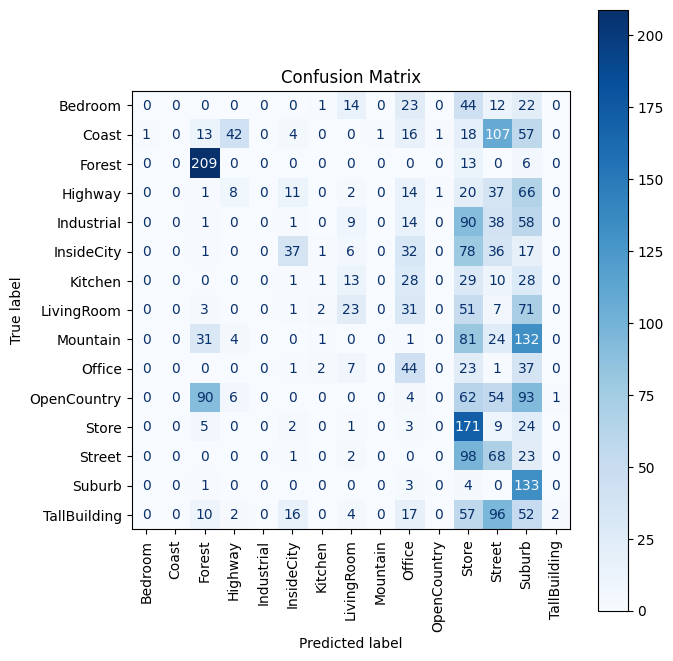

In [15]:
# prepare the matrix for test 
K_test = chi2_kernel(X_test, X_train, A=A)

y_pred_gauss = []

for i in range(len(X_test)):
    # extract the i-th row 
    kernel_row = K_test[i].reshape(1, -1)

    scores = np.array([svm_gaussian.decision_function(kernel_row)[0] for svm_gaussian in classifiers_gaussian])

    pred_index = np.argmax(scores)
    pred_class = class_names[pred_index]
    y_pred_gauss.append(pred_class)

accuracy_gauss = accuracy_score(y_test_true, y_pred_gauss)
print(f"The accuracy of the multiclass SVM using the gaussian kernel is: {accuracy_gauss}")

cm_prediction_gaussian = confusion_matrix(y_test_true, y_pred_gauss, labels=class_names)

fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_prediction_gaussian, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title(f"Confusion Matrix")
plt.tight_layout()
plt.show()

In this case, the accuracy is even lower.

The classification was very accurate only for the following categories: 
- **Forest**: 209 out of 228 images were correctly classified; 
- **Suburb**: 133 out of 141 images were correcly classified; 
- **Store**: 171 out of 213 images were correctly classified. 

For the other categories, the kernel does not work properly. 